# Anime (Japanese Style Animation) Recommendation System

**Reference:** https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation/notebook

## Libraries

In [1]:
import re
import os
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

## Import Data

In [2]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
anime = pd.read_csv(csv_files[0])
ratings = pd.read_csv(csv_files[1])

## Data Exploration 

### Anime Dataframe

In [3]:
anime.head(3).T

,0,1,2
MAL_ID,1,5,6
Name,Cowboy Bebop,Cowboy Bebop: Tengoku no Tobira,Trigun
Score,8.78,8.39,8.24
Genres,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","Action, Drama, Mystery, Sci-Fi, Space","Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
English name,Cowboy Bebop,Cowboy Bebop:The Movie,Trigun
Japanese name,カウボーイビバップ,カウボーイビバップ 天国の扉,トライガン
Type,TV,Movie,TV
Episodes,26,1,26
Aired,"Apr 3, 1998 to Apr 24, 1999","Sep 1, 2001","Apr 1, 1998 to Sep 30, 1998"
Premiered,Spring 1998,Unknown,Spring 1998


In [4]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [5]:
anime.shape

(17562, 35)

### Ratings Dataframe

In [6]:
ratings.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [8]:
ratings.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [9]:
ratings['rating'].unique()

array([ 9,  5,  7,  8, 10,  6,  4,  3,  2,  1])

In [10]:
ratings.shape[0]

57633278

### EDA

In [11]:
#Rating Count
rating_count = ratings.groupby('rating')['rating'].agg(['count'])
rating_count = rating_count.reset_index()
rating_count['perc'] = (rating_count['count']/ratings.shape[0]) * 100

#Movie Count
anime_count = anime.shape[0]

#Customer Count
cust_count = ratings['user_id'].nunique() - anime_count

#Rating Count
total_ratings_counted = ratings['user_id'].count() - anime_count

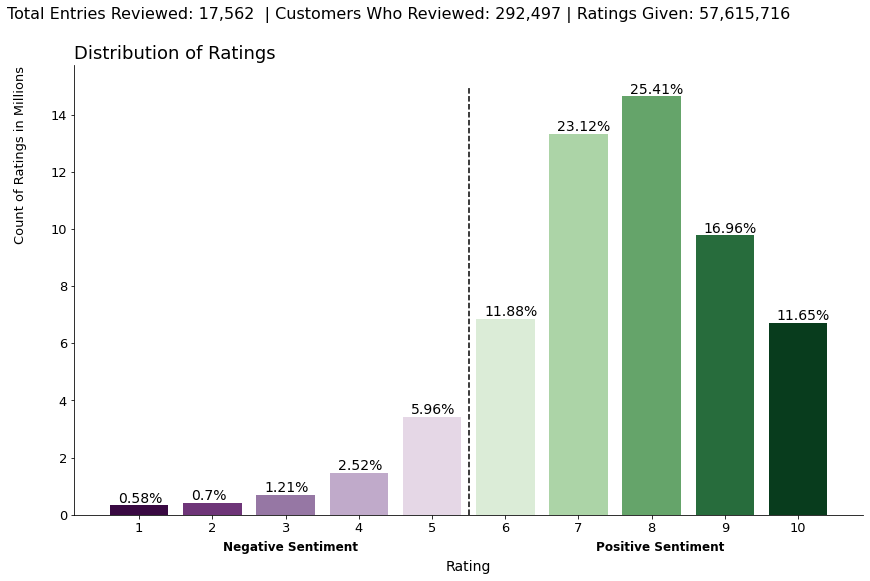

In [12]:
#Plot
fig, ax = plt.subplots(figsize = (12,8))

#Color Palette's 
colors = ['#00429d', '#3e67ae', '#618fbf', '#85b7ce', '#b1dfdb', '#ffcab9', '#fd9291', '#e75d6f', '#c52a52', '#93003a'] 
colors2 = ['#8e0152','#c51b7d', '#de77ae', '#f1b6da', '#fde0ef', '#e6f5d0', '#b8e186', '#7fbc41', '#4d9221', '#276419']
colors3 = ['#40004b','#762a83', '#9970ab', '#c2a5cf', '#e7d4e8', '#d9f0d3', '#a6dba0', '#5aae61', '#1b7837', '#00441b']
colors4 = ['#7f3b08','#b35806', '#e08214', '#fdb863', '#fee0b6', '#d8daeb', '#b2abd2', '#8073ac', '#542788', '#2d004b']

sns.barplot(x = rating_count['rating'], y = rating_count['count'], palette = colors3)

#Remove Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Title & Axis Labels
plt.title('Distribution of Ratings', fontsize = 18, loc = 'left')
plt.suptitle('Total Entries Reviewed: {:,}  | Customers Who Reviewed: {:,} | Ratings Given: {:,}'.format(anime_count, cust_count, total_ratings_counted), 
          fontsize=16, x = 0.45, y = 1)

#Y-Axis
ax.set_yticks([0,2.0e+06,4.0e+06,6.0e+06,8.0e+06,1.0e+07,1.2e+07,1.4e+07])
ax.set_yticklabels([0, 2, 4, 6, 8, 10, 12, 14], fontsize = 13)
ax.set_ylabel('Count of Ratings in Millions', fontsize = 13)
ax.yaxis.set_label_coords(-.06, .8)

#X-Axis
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize = 13)
ax.set_xlabel('Rating', fontsize = 14)
ax.xaxis.set_label_coords(0.5,-0.1)

#Vertical Line
ax.vlines(4.5, 0, 1.5e+7, linestyles='dashed', colors='black',clip_on = False)

#Annotations
ax.text(0.189, -0.08, 'Negative Sentiment',transform=ax.transAxes, fontsize = 12, fontweight = 'demi')
ax.text(0.661, -0.08, 'Positive Sentiment',transform=ax.transAxes, fontsize = 12, fontweight = 'demi')

#Annotating Percentages to bar
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.11, i.get_height()+100000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=14)
        
plt.tight_layout()
plt.show()

In [13]:
anime_remove_unknown = anime.copy()
anime_remove_unknown = anime.loc[(anime['Type'] != 'Unknown') & (anime['Score'] != 'Unknown')]
anime_remove_unknown['Score'] = pd.to_numeric(anime_remove_unknown['Score'], downcast="float")

/var/folders/hg/0r3dxxf938z4yxhyv925kjzr0000gn/T/ipykernel_24760/2365221012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_remove_unknown['Score'] = pd.to_numeric(anime_remove_unknown['Score'], downcast="float")


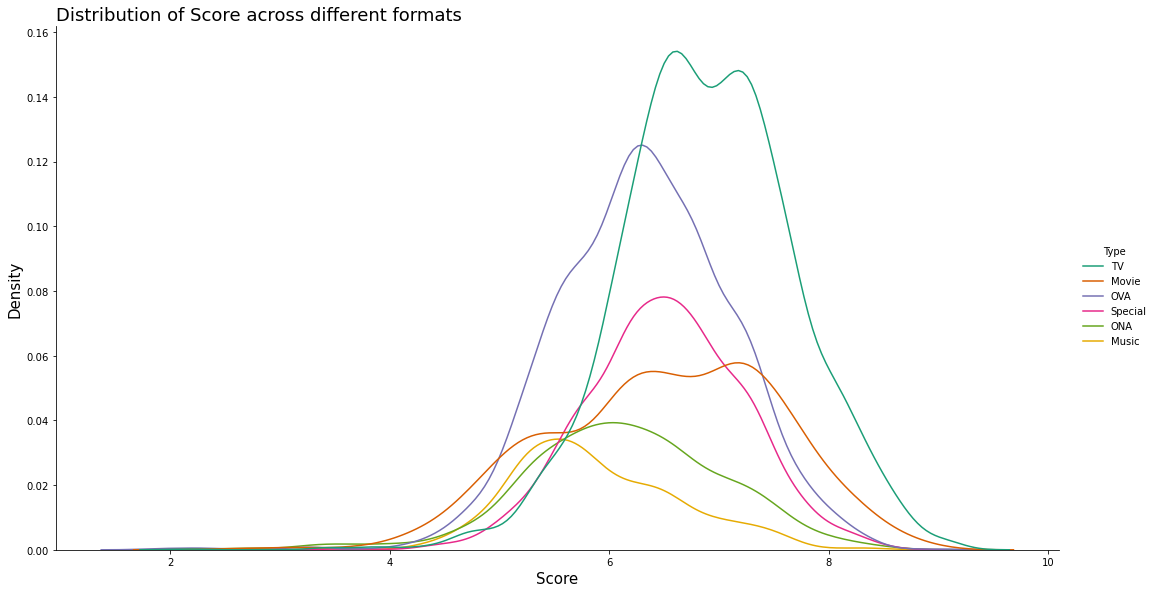

In [14]:
palette1 = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
palette2 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']

sns.displot(data=anime_remove_unknown, x="Score", hue="Type", kind="kde"
            ,height=8, aspect=15/8, palette = palette2)

plt.title('Distribution of Score across different formats', fontsize = 18, loc = 'left')

plt.xlabel('Score', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

#Remove Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Data Cleaning

In [15]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [16]:
#Columns that are not necessary 
anime_clean = anime.drop(['Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors','Popularity','Members',
       'Studios', 'Source', 'Duration', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'], axis = 1)

### Data Slicing

- Anime entries with low ratings are removed as these are not popular
- Users who have submitted a small amount of reviews are removed as they are not active

In [17]:
#A dataframe containing valid rating entries, non-null values
df = ratings[pd.notnull(ratings['rating'])]

In [18]:
f = ['count', 'mean'] #Aggregate functions 
df_anime_summary = ratings.groupby('anime_id')['rating'].agg(f) #Grouping different anime's by average rating and rating count
df_anime_summary.index = df_anime_summary.index.map(int)
anime_benchmark = round(df_anime_summary['count'].quantile(0.8),0) #Anime with ratings less than this, will be removed

#List of the anime to drop
drop_anime_list = df_anime_summary.loc[df_anime_summary['count'] < anime_benchmark].index

print('Anime minimum times of review: {}'.format(anime_benchmark))

Anime minimum times of review: 2789.0


In [19]:
df_user_summary = ratings.groupby('user_id')['rating'].agg(f) #Grouping different users by average rating and rating count
df_user_summary.index = df_user_summary.index.map(int)
user_benchmark = round(df_user_summary['count'].quantile(0.8),0) #Users with less reviews than this, will be removed

#List of users to be removed
drop_user_list = df_user_summary.loc[df_user_summary['count'] < user_benchmark].index

print('User minimum times of review: {}'.format(user_benchmark))

User minimum times of review: 281.0


In [20]:
print('Original Shape: {}'.format(df.shape))

#Removing anime and users that do not fit into the benchmark from the dataframe
df = df[~df['anime_id'].isin(drop_anime_list)]
df = df[~df['user_id'].isin(drop_user_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::500000, :])

Original Shape: (57633278, 3)
After Trim Shape: (29141216, 3)
-Data Examples-
          user_id  anime_id  rating
189             3     25835       8
1010173      6505     21881       8
1964912     12164      6547       5
2950676     18193     33486       8
3936958     24264      6444       6
4922471     30206     11887       7
5915578     36310     24151       9
6903738     42407      6880       9
7898567     48462        47      10
8858952     54238     38000       6
9857392     60516      1575      10
10825386    66274     25835       4
11838892    72513     22535       9
12853855    78791     12477       8
13840016    84886      6895       7
14853754    91114     30363       4
15860652    97361     31821       7
16840586   103409     20507       6
17826559   109448     13335       6
18806303   115482      1943       8
19817766   121866       389       8
20799434   127858     35466       9
21758327   133558     18671      10
22756460   139728     33926       8
23759768   146103     

### Data Mapping

In [21]:
#Set 'MAL_ID' as index
anime_clean.set_index('MAL_ID', inplace = True)

In [22]:
anime_clean.head()

,Name,Score,Rating,Ranked
MAL_ID,,,,
1,Cowboy Bebop,8.78,R - 17+ (violence & profanity),28.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,R - 17+ (violence & profanity),159.0
6,Trigun,8.24,PG-13 - Teens 13 or older,266.0
7,Witch Hunter Robin,7.27,PG-13 - Teens 13 or older,2481.0
8,Bouken Ou Beet,6.98,PG - Children,3710.0


### Recommendation with Collaborative Filtering

In [23]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['user_id', 'anime_id', 'rating']][:100000], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([2.94887169, 2.93081363, 2.94549773, 2.94346926, 2.95611108]),
 'test_mae': array([2.61641675, 2.60724035, 2.62261992, 2.61804519, 2.62685122]),
 'fit_time': (4.069001913070679,
  4.133916139602661,
  4.054877042770386,
  4.0320398807525635,
  4.076335191726685),
 'test_time': (0.09392690658569336,
  0.18805289268493652,
  0.0796971321105957,
  0.12980103492736816,
  0.08034515380859375)}

In [24]:
df

,user_id,anime_id,rating
189,3,25835,8
190,3,28171,8
191,3,32282,8
192,3,35788,9
193,3,9253,9
...,...,...,...
57633027,353398,37614,7
57633028,353398,33421,6
57633029,353398,37007,4
57633030,353398,28825,6


#### User Rating History

In [25]:
random_sample = df.sample(n = 1)
random_sample = int(random_sample['user_id'])
print('Random User ID: ', random_sample)

Random User ID:  23149


In [26]:
user_history = df[(df['user_id'] == random_sample) & (df['rating'] == 5)]
user_history = user_history.set_index('anime_id')
user_history = user_history.join(anime_clean['Name'])
print(user_history)

          user_id  rating                                               Name
anime_id                                                                    
899         23149       5  Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Po...
29589       23149       5                                 Denpa Kyoushi (TV)
14893       23149       5  Dakara Boku wa, H ga Dekinai.: Mie Sugi! Mizug...
12549       23149       5                      Dakara Boku wa, H ga Dekinai.
17397       23149       5                              Cyclops Shoujo Saipuu
40064       23149       5  Dungeon ni Deai wo Motomeru no wa Machigatteir...
13263       23149       5           Fate/Zero: Onegai! Einzbern Soudanshitsu
20365       23149       5                    Another: Misaki Mei - Shizukani
713         23149       5                                          Air Movie
5112        23149       5                                            Akikan!
12505       23149       5                        C³: Rikan Gakkou Confusion!

#### Recommendations for Random User

In [27]:
random_user_rec = anime_clean.copy()
random_user_rec = random_user_rec.reset_index()
random_user_rec = random_user_rec[~random_user_rec['MAL_ID'].isin(drop_anime_list)]

In [28]:
# getting full dataset
data = Dataset.load_from_df(df[['user_id', 'anime_id', 'rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

random_user_rec['Estimate_Score'] = random_user_rec['MAL_ID'].apply(lambda x: svd.predict(random_sample, x).est)

random_user_rec = random_user_rec.drop('MAL_ID', axis = 1)

random_user_rec = random_user_rec.sort_values('Estimate_Score', ascending=False)

In [29]:
random_user_rec.head(10)

,Name,Score,Rating,Ranked,Estimate_Score
0,Cowboy Bebop,8.78,R - 17+ (violence & profanity),28.0,5.0
11196,Hibike! Euphonium 2,8.3,PG-13 - Teens 13 or older,228.0,5.0
11129,Arslan Senki (TV): Fuujin Ranbu,7.53,PG-13 - Teens 13 or older,1484.0,5.0
11140,Ojisan to Marshmallow,6.6,PG-13 - Teens 13 or older,5348.0,5.0
11143,Hai to Gensou no Grimgar,7.69,PG-13 - Teens 13 or older,1061.0,5.0
11165,Big Order (TV),5.4,R+ - Mild Nudity,9909.0,5.0
11170,Shoujo-tachi wa Kouya wo Mezasu,6.33,PG-13 - Teens 13 or older,6742.0,5.0
11171,Owaranai Seraph: Nagoya-hen,7.31,PG-13 - Teens 13 or older,2306.0,5.0
11178,Full Metal Panic! Invisible Victory,7.6,R - 17+ (violence & profanity),1281.0,5.0
11179,JoJo no Kimyou na Bouken Part 4: Diamond wa Ku...,8.51,R - 17+ (violence & profanity),100.0,5.0


### Recommendation using Pearsons R Correlation

#### Pivot Dataframe

In [30]:
ratings_pivot = pd.pivot_table(df,values='rating',index='user_id',columns='anime_id')

print(ratings_pivot.shape)

(62086, 3376)


In [31]:
def recommend(anime_title, min_count):
    print("For Anime : {}".format(anime_title))
    print("- Top 10 Anime recommended based on Pearsons' R correlation -")
    i = int(anime_clean.index[anime_clean['Name'] == anime_title][0])
    target = ratings_pivot[i]
    similar_to_target = ratings_pivot.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(anime_clean).join(df_anime_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [38]:
recommend("Fairy Tail", 0)

For Anime : Fairy Tail
- Top 10 Anime recommended based on Pearsons' R correlation -
 PearsonR                                                Name  count     mean
 1.000000                                          Fairy Tail  66828 7.905713
 0.847075                                   Fairy Tail (2014)  34384 7.853973
 0.757795                                      Fairy Tail OVA  17650 7.418017
 0.724915                            Fairy Tail: Final Series  13729 7.543740
 0.712587                   Fairy Tail Movie 1: Houou no Miko  19733 7.344702
 0.673927                                   Fairy Tail x Rave  13093 7.118002
 0.672335                               Fairy Tail OVA (2016)   6153 7.064684
 0.657984                      Fairy Tail Movie 2: Dragon Cry   9807 7.370654
 0.644841 Fairy Tail Movie 1: Houou no Miko - Hajimari no Asa   8848 7.173033
 0.625177                                    Sword Art Online 161192 7.403593
